# LAB 5. Hypothesis testing. Green taxi case.


Test various hypotheses about ridership volume and trip characteristics for green taxi trips in 2019-2020. 

Does the ridership decline over time? Does it depend on the day of the week and time of the day? Does the distribution of the trip parameters (distance, time, speed) depend on the day of the week and borough?

In [1]:
#import the modules
import pandas as pd
import geopandas as gpd
import urllib.request
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('green_taxi/'):
    pass
else:
    os.makedirs('green_taxi')

for year in [2019,2020]:
    for month in range(1,13):
        urllib.request.urlretrieve ("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')), 
                                    "green_taxi/green_tripdata_%s-%s.parquet"%(str(year),str(month).rjust(2, '0')))

In [4]:
dfTaxi = pd.read_parquet('green_taxi/')
dfTaxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2018-12-21 15:17:29,2018-12-21 15:18:57,N,1.0,264,264,5.0,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2.0,1.0,NaN
1,2,2019-01-01 00:10:16,2019-01-01 00:16:32,N,1.0,97,49,2.0,0.86,6.0,0.5,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,NaN
2,2,2019-01-01 00:27:11,2019-01-01 00:31:38,N,1.0,49,189,2.0,0.66,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,1.0,1.0,NaN
3,2,2019-01-01 00:46:20,2019-01-01 01:04:54,N,1.0,189,17,2.0,2.68,13.5,0.5,0.5,2.96,0.0,NaN,0.3,19.71,1.0,1.0,NaN
4,2,2019-01-01 00:19:06,2019-01-01 00:39:43,N,1.0,82,258,1.0,4.53,18.0,0.5,0.5,0.00,0.0,NaN,0.3,19.30,2.0,1.0,NaN


In [5]:
#take care of the timestamp types
dfTaxi['lpep_pickup_datetime'] = pd.to_datetime(dfTaxi['lpep_pickup_datetime'])
dfTaxi['lpep_dropoff_datetime'] = pd.to_datetime(dfTaxi['lpep_dropoff_datetime'])

In [6]:
#extract date, year, day of the week and hour (takes some time around half a minute)
dfTaxi['Date'] = dfTaxi['lpep_pickup_datetime'].dt.date
dfTaxi['Month'] = dfTaxi['lpep_pickup_datetime'].dt.month
dfTaxi['Year'] = dfTaxi['lpep_pickup_datetime'].dt.year
dfTaxi['DOW'] = dfTaxi['lpep_pickup_datetime'].dt.dayofweek
dfTaxi['Hour'] = dfTaxi['lpep_pickup_datetime'].dt.hour
dfTaxi = dfTaxi.loc[dfTaxi['Year'].isin([2019,2020])]

In [7]:
#calculate trip duration in minutes
dfTaxi['trip_duration'] = (dfTaxi['lpep_dropoff_datetime'] - dfTaxi['lpep_pickup_datetime'])
dfTaxi['trip_duration'] = dfTaxi['trip_duration'].dt.total_seconds() / 60

In [8]:
dfTaxi['speed'] = dfTaxi['trip_distance'] / (dfTaxi['trip_duration'] / 60) #avg trip speed in miles per hour

In [9]:
len(dfTaxi) #original number of records

8034894

In [10]:
#sanity filtering
dfTaxi = dfTaxi[(dfTaxi.trip_distance < 100)& (dfTaxi.speed <= 80) & (dfTaxi.speed >= 1) & (dfTaxi.trip_duration <= 100) & (dfTaxi.trip_duration >= 1)]
len(dfTaxi) #remaining records

7695559

In [11]:
#daily total trip counts and cumulative duration and distance traveled
dfTaxiDaily = dfTaxi.groupby(['Year','Month','DOW','Date']).\
            agg({'lpep_pickup_datetime':'count','trip_duration':'sum','trip_distance':'sum'}).\
            rename(columns={'lpep_pickup_datetime':'trip_count'}).reset_index()
dfTaxiDaily = dfTaxiDaily.sort_values(by='Date')

In [12]:
dfTaxiDaily['speed'] = dfTaxiDaily['trip_distance'] / dfTaxiDaily['trip_duration'] * 60

In [13]:
dfTaxiDaily.head()

,Year,Month,DOW,Date,trip_count,trip_duration,trip_distance,speed
4,2019,1,1,2019-01-01,14806,204573.783333,58685.45,17.212015
9,2019,1,2,2019-01-02,19337,313291.066667,78826.38,15.096450
14,2019,1,3,2019-01-03,21199,354189.416667,85026.18,14.403510
19,2019,1,4,2019-01-04,22445,365281.183333,87954.88,14.447207
23,2019,1,5,2019-01-05,20196,281748.833333,71442.58,15.214100


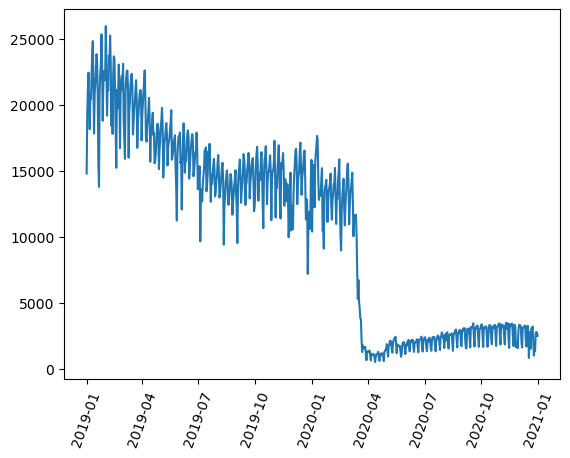

In [14]:
#ridership timeline - daily trip counts; seem to decline and particularly during the pandemics lockdown
plt.plot(dfTaxiDaily['Date'], dfTaxiDaily['trip_count'])
plt.xticks(rotation=70);
plt.show()

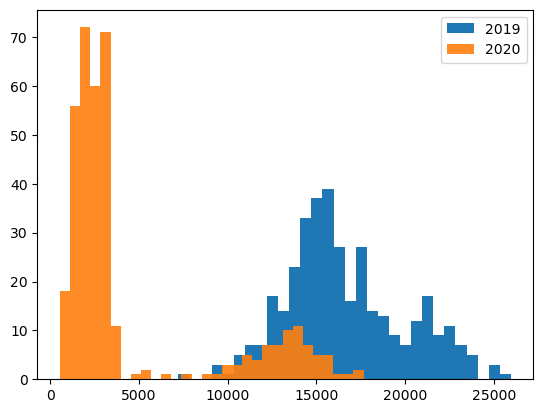

In [15]:
#histograms of daily counts in 2019 and 2018 - distributions look different
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'].values,bins=30,label='2019')
plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.9,label='2020')
#plt.hist(dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'].values,bins=30,alpha=0.5,label='2020')
plt.legend()
plt.show()

2020 daily ride numbers are vastly different from 2019 numbers, due to the pandemic

In [16]:
## t-test between the 2019 and 2020 distributions
stats.ttest_ind(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'])

TtestResult(statistic=41.1514006319882, pvalue=2.831484024261312e-192, df=729.0)

In [17]:
## K-S test
stats.ks_2samp(dfTaxiDaily.loc[dfTaxiDaily['Year']==2019]['trip_count'],dfTaxiDaily.loc[dfTaxiDaily['Year']==2020]['trip_count'])

KstestResult(statistic=0.8059735010105546, pvalue=4.9185688151122775e-120, statistic_location=10488, statistic_sign=-1)

So the hypothesis that 2019 and 2020 daily trip counts follow the same distributions can be rejected beyond any reasonable doubt

In [18]:
#For further analysis select the year 2019
dfTaxiDaily2019 = dfTaxiDaily.loc[dfTaxiDaily['Year']==2019] #daily aggregates
dfTaxi2019 = dfTaxi.loc[dfTaxi['Year']==2019] #individual trips
(dfTaxiDaily2019['trip_count'].sum(),len(dfTaxi2019)) #total trip counts in either dataset

(6050571, 6050571)

## Example 1. Test if weekend ridership is different from weekday

In [19]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# t-test
stats.ttest_ind(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

TtestResult(statistic=-3.4042707657462894, pvalue=0.0007375120140568516, df=363.0)

In [20]:
# Monday is 0, Sunday is 6; weekends: DOW>4, weekdays: DOW<=4
# KS-test
stats.ks_2samp(dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']>4]['trip_count'],
                dfTaxiDaily2019.loc[dfTaxiDaily2019['DOW']<=4]['trip_count'])

KstestResult(statistic=0.21198054818744475, pvalue=0.0020180944149611403, statistic_location=13746, statistic_sign=1)

Reject the hypothesis that weekends and weekdays follow the same ridership distribution at 95\% significance level

## Example 2. Test if trip speed, duration or distance follow log-normal distributions

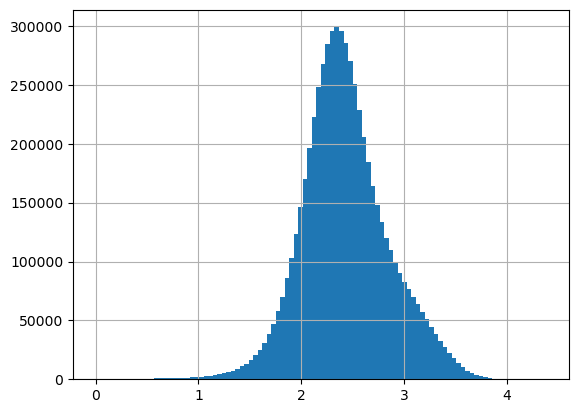

In [21]:
#analyze the overall speed distribution (plot on log-scale)
np.log(dfTaxi2019['speed']).hist(bins=100)
plt.show()

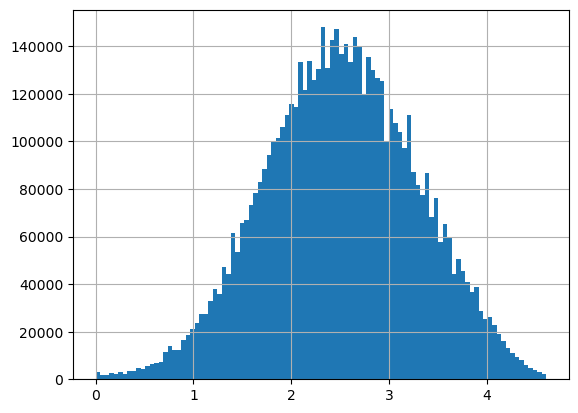

In [22]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_duration']).hist(bins=100)
plt.show()

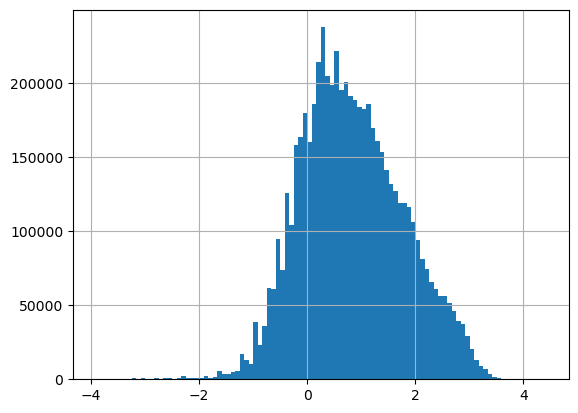

In [23]:
#analyze the overall duration distribution (plot on log-scale)
np.log(dfTaxi2019['trip_distance']).hist(bins=100)
plt.show()

In [24]:
def is_normal(x): #check is the distribution is normal using one-sample KS test and sample mean-std
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [25]:
# is log-speed normally distributed?
is_normal(np.log(dfTaxi2019['speed']))

KstestResult(statistic=0.04112504444412968, pvalue=0.0, statistic_location=2.553899521274952, statistic_sign=1)

In [26]:
# is log-duration normally distributed?
is_normal(np.log(dfTaxi2019['trip_duration']))

KstestResult(statistic=0.0099106695254213, pvalue=0.0, statistic_location=3.2188758248682006, statistic_sign=-1)

In [27]:
# is log-distance normally distributed?
is_normal(np.log(dfTaxi2019['trip_distance']))

KstestResult(statistic=0.038052087226460696, pvalue=0.0, statistic_location=0.5306282510621704, statistic_sign=1)

In [28]:
#so none of those quantities have log-normal distribution (rejecting with 99.9999...% confidence)

In [29]:
#what about daily average trip_count, duration, distance, speed?

In [30]:
is_normal(dfTaxiDaily2019['trip_count']) #does not look normal

KstestResult(statistic=0.08976513787910678, pvalue=0.0052161800054339475, statistic_location=15924, statistic_sign=1)

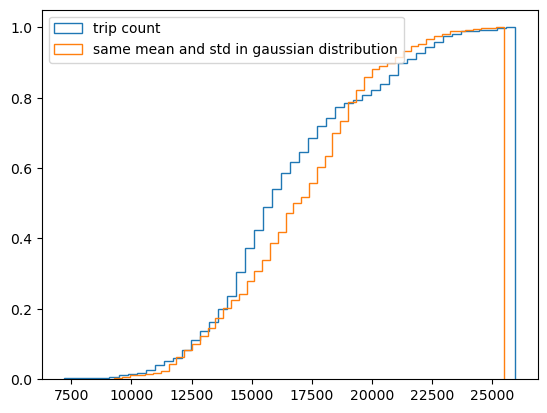

In [31]:
#visualize empiric CDF's for trip-counts
plt.hist(dfTaxiDaily2019['trip_count'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip count')
plt.hist(np.random.normal(dfTaxiDaily2019['trip_count'].mean(), dfTaxiDaily2019['trip_count'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')
plt.show()

In [32]:
is_normal(np.log(dfTaxiDaily2019['trip_count'])) #but might be log-normal

KstestResult(statistic=0.05178617029731869, pvalue=0.2720966555306574, statistic_location=9.929691218032765, statistic_sign=-1)

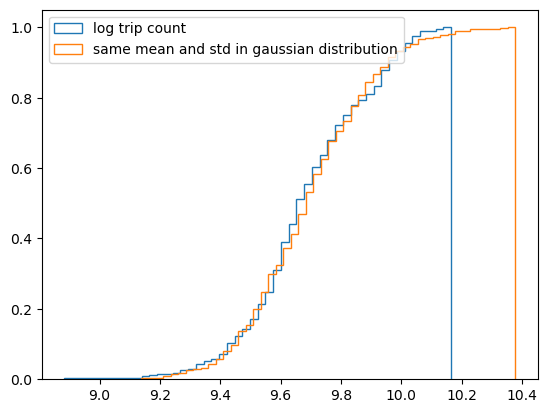

In [33]:
#visualize empiric CDF's for log trip-counts
plt.hist(np.log(dfTaxiDaily2019['trip_count'].values), 50, density=True, 
         histtype='step',cumulative=True,label='log trip count')
plt.hist(np.random.normal(np.log(dfTaxiDaily2019['trip_count']).mean(), np.log(dfTaxiDaily2019['trip_count']).std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std in gaussian distribution')
plt.legend(loc='upper left')
plt.show()

In [34]:
is_normal(dfTaxiDaily2019['trip_duration']) #could be normal

KstestResult(statistic=0.08627672246372531, pvalue=0.00819631097004777, statistic_location=294726.48333333334, statistic_sign=1)

<Axes: >

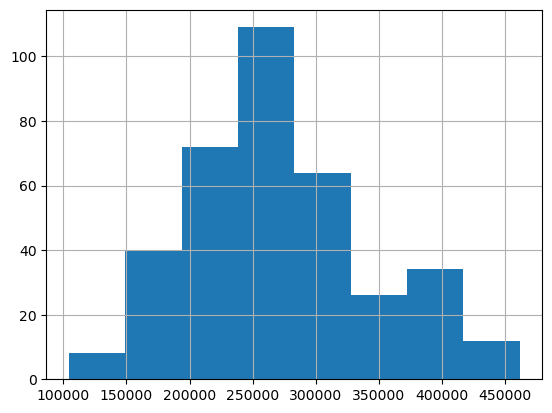

In [35]:
dfTaxiDaily2019['trip_duration'].hist(bins=8)

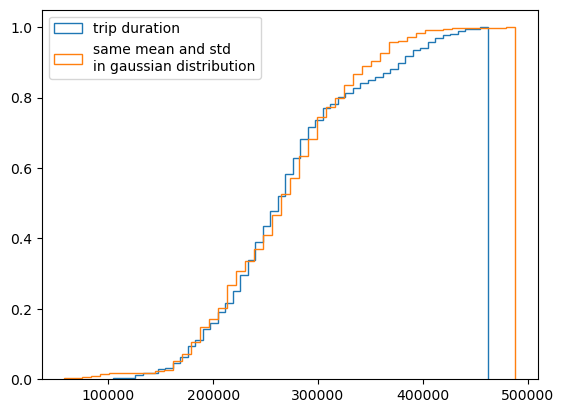

In [36]:
_ = plt.hist(dfTaxiDaily2019['trip_duration'].values, 50, density=True, 
         histtype='step',cumulative=True,label='trip duration')
_ = plt.hist(np.random.normal(dfTaxiDaily2019['trip_duration'].mean(), 
                              dfTaxiDaily2019['trip_duration'].std(),
                          len(dfTaxiDaily2019)), 50, density=True, 
         histtype='step',cumulative=True,label='same mean and std \nin gaussian distribution')
plt.legend(loc='upper left')
plt.show()

In [37]:
is_normal(dfTaxiDaily2019['trip_distance']) #does not look normal

KstestResult(statistic=0.17162133299223226, pvalue=7.188960711147288e-10, statistic_location=61169.01, statistic_sign=1)

In [38]:
is_normal(np.log(dfTaxiDaily2019['trip_distance'])) #but might be log-normal

KstestResult(statistic=0.12270218424241863, pvalue=3.0126880620963445e-05, statistic_location=11.021395967701523, statistic_sign=1)

In [39]:
is_normal(dfTaxiDaily2019['speed']) #might be normal

KstestResult(statistic=0.0762848602607275, pvalue=0.027082997184901925, statistic_location=12.833311327932032, statistic_sign=1)

In [40]:
is_normal(np.log(dfTaxiDaily2019['speed'])) #log-normal even more likely

KstestResult(statistic=0.06791069917206083, pvalue=0.0658566226345636, statistic_location=2.552044237917564, statistic_sign=1)

## Research questions to further explore (just extra-curricular suggestions - this is NOT HOMEWORK)
- Which weekdays are similar/different in terms of avg.travel speed distributions?
- Are evening/morning/afternoon trip speed, duration and distance distributions significantly different?
- Are trip speed, duration and distance distributions different in Brooklyn vs Queens or Bronx? 
- No doubt that 2020 saw a large drop in ridership but how can we assess it? As we don't have the full year, the drop just started in March and there is also a general decline, consider the 2020/2019 ratios (to account for the general trend and seasonality and see how much more steep is the drop during the pandemics). Compare the pandemics numbers (After March 2020 with the same period pre-march 2020). Also compare the post-pandemics and pre-pandemics travel distance, speed and duration distributions

## Homework Task. Travel speed - days of the week
Traffic and travel speed may vary during different weekdays. a) Compute the average travel speed per each of the 7 days of the week (among all the individual trips happening on Mondays, Tuesdays, Wednesdays etc); visualize those as a bar plot. Then compute the average travel speed per each day of the year and perform a pairwise comparison between the distributions of the daily speed averages within different days of the week (i.e. distribution of all Monday avg speeds vs all Tuesday avg speeds etc). Compute p-value of the ks-test for each pair of the different weekdays and compare with 5\%. As a result, we are expecting a 7*7 pandas dataframe filled with "reject" (if p-value below 5\%), "keep" (if p-value above 5\%) and "-" on the diagonal.